# Import packages

In [33]:
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import datetime
import matplotlib.ticker as mticker

# Compute the speed

In [34]:
def compute_speed(record):
    timestamps = np.array(record['timestamp']) / 1000
    local_y_positions = np.array(record['local_y'])
    
    # 确保数据按时间排序
    sorted_indices = np.argsort(timestamps)
    timestamps = timestamps[sorted_indices]
    local_y_positions = local_y_positions[sorted_indices]

    timestamps += 9 * 3600
    
    # 计算速度
    speed = np.diff(local_y_positions) / np.diff(timestamps)
    speed = np.append(speed[0], speed)  # 保持速度数组与位置数组长度一致
    speed *= 0.681818  # 将单位从 ft/sec 转换为 mph
    
    return timestamps, local_y_positions, speed

# Set plot environment

In [35]:
def plot_trajectory(record, ax_dict, cmap, all_timestamps):
    timestamps, positions, speed = compute_speed(record)
    # 转换位置单位为米
    positions = positions * 0.3048
    lane_id = record.get('lane_id', None)
    if isinstance(lane_id, list):
        lane_id = lane_id[0]  # 如果是列表，取第一个元素
    if lane_id in ax_dict:
        # 绘制轨迹
        im = ax_dict[lane_id].scatter(timestamps, positions, c=speed, cmap=cmap, vmin=0, vmax=55, s=0.01)
        all_timestamps[lane_id].extend(timestamps)
        return im
    return None

def setup_plot(lane_id):
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(10, 3))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # 定义颜色范围
    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)
    
    ax.set_title(f'Trajectories for Lane {lane_id}')
    
    return fig, ax, green_to_red, cax

# Operation zone

Plotted 200 trajectories
Plotted 400 trajectories
Plotted 600 trajectories
Plotted 800 trajectories
Plotted 1000 trajectories
Plotted 1200 trajectories
Plotted 1400 trajectories
Plotted 1600 trajectories
Data loading time: 15.761565685272217


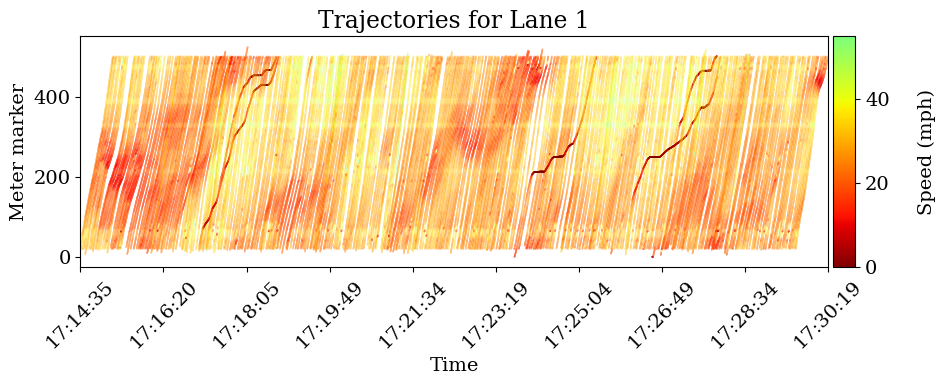

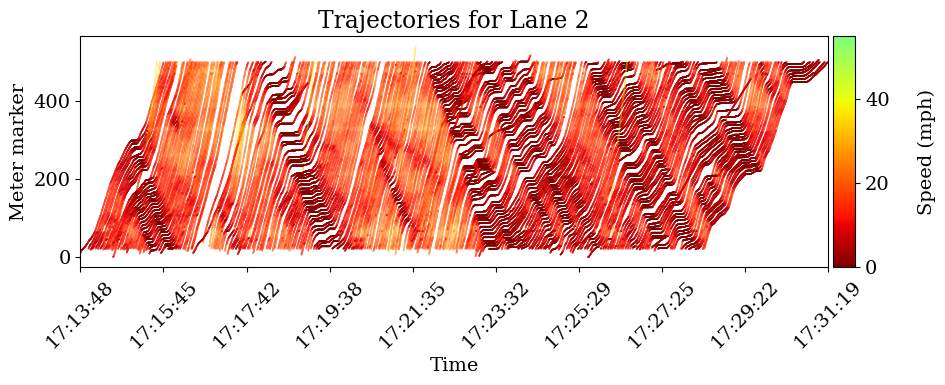

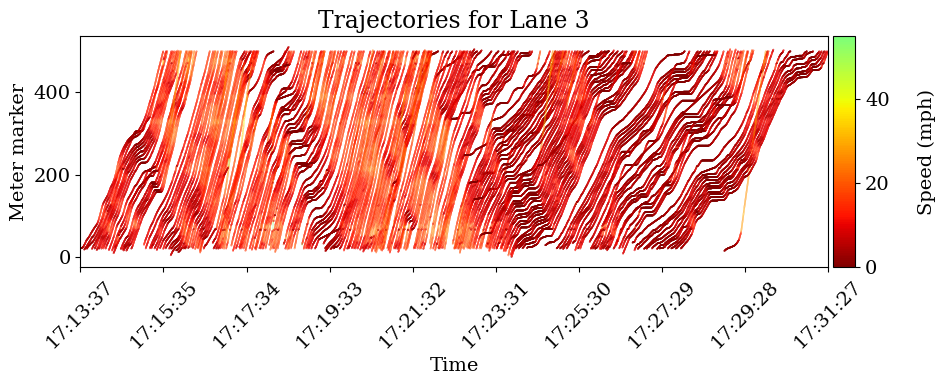

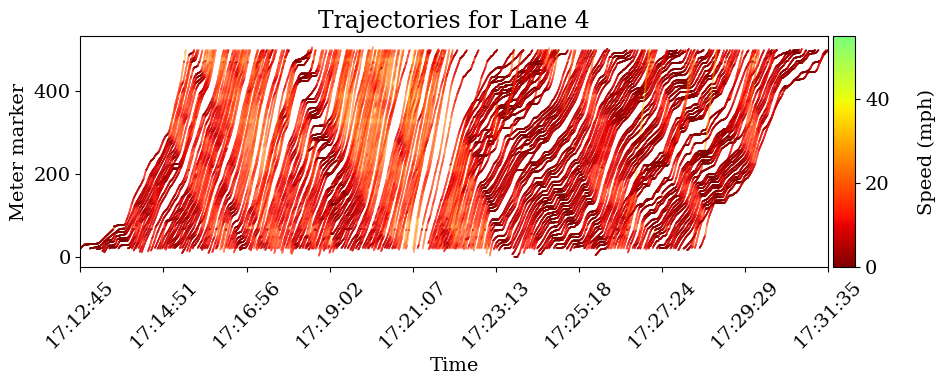

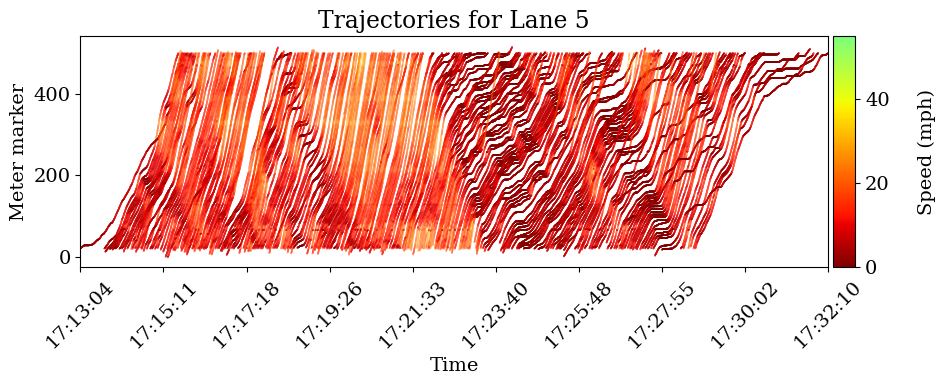

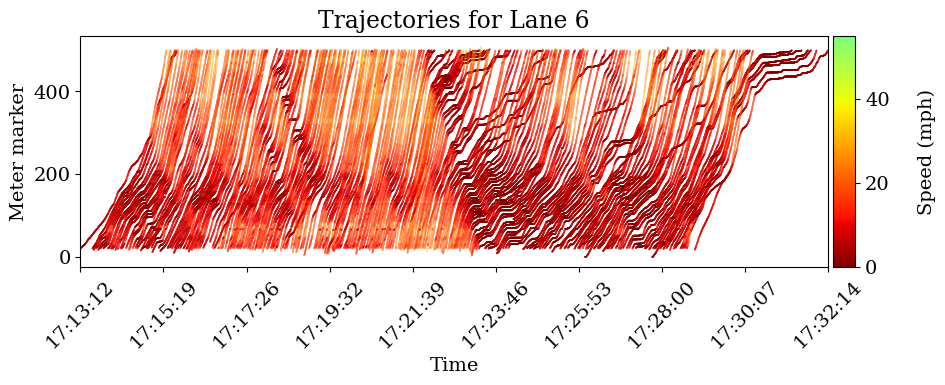

Total elapsed time: 49.485480070114136


In [36]:
# 修改后的第四部分

# 绘制函数操作
input_file = 'trajectories-0515-0530.json'

# Set environment
lane_ids = range(1, 7)  # 1到6车道
fig_dict = {}
ax_dict = {}
cax_dict = {}
all_timestamps = {lane_id: [] for lane_id in lane_ids}

# 定义颜色范围
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

for lane_id in lane_ids:
    fig, ax, cmap, cax = setup_plot(lane_id)
    fig_dict[lane_id] = fig
    ax_dict[lane_id] = ax
    cax_dict[lane_id] = cax

# 读取并处理JSON文件
t = time.time()
with open(input_file, 'r') as input_file:
    i = 0
    for line in input_file:
        record = json.loads(line)
        im = plot_trajectory(record, ax_dict, green_to_red, all_timestamps)
        i += 1
        if i % 200 == 0:
            print(f"Plotted {i} trajectories")
        if i >= 5000:  # 控制最大绘制轨迹数
            break

print(f"Data loading time: {time.time() - t}")

# 更新颜色条和坐标轴标签
for lane_id in lane_ids:
    ax = ax_dict[lane_id]
    fig = fig_dict[lane_id]
    cax = cax_dict[lane_id]
    if all_timestamps[lane_id]:
        plt.colorbar(ax.collections[0], cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
        ax.set_xlabel("Time")
        ax.set_ylabel("Meter marker")

        min_timestamp = min(all_timestamps[lane_id])
        max_timestamp = max(all_timestamps[lane_id])
        ax.set_xlim([min_timestamp, max_timestamp])
        
        # 将时间分成若干段
        num_ticks = 10  # 假设需要10个刻度
        ticks = np.linspace(min_timestamp, max_timestamp, num_ticks)
        ax.set_xticks(ticks)
        
        # 更新x轴时间为可读格式
        x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks]
        labels = [d.strftime('%H:%M:%S') for d in x_datetime]
        ax.set_xticklabels(labels, rotation=45)

# 显示所有图
plt.show()

print(f"Total elapsed time: {time.time() - t}")
